<a href="https://colab.research.google.com/github/Tejaswi37/2303A51944-Batch-27-/blob/main/unsupervised_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== Logistic Regression ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'C': 100, 'solver': 'lbfgs'}
Accuracy: 91.69%
Classification Report:
              precision    recall  f1-score   support

       HI_HD       0.99      0.61      0.76       676
       HI_HS       0.96      0.99      0.98       515
       LI_LS       0.99      1.00      1.00       852
       MI_HD       0.84      0.99      0.91      1290

    accuracy                           0.92      3333
   macro avg       0.95      0.90      0.91      3333
weighted avg       0.93      0.92      0.91      3333


=== KNN ===
Best parameters: {'n_neighbors': 9, 'weights': 'distance'}
Accuracy: 61.84%
Classification Report:
              precision    recall  f1-score   support

       HI_HD       0.51      0.29      0.37       676
       HI_HS       0.52      0.43      0.47       515
       LI_LS       0.82      0.71      0.76       852
       MI_HD       0.58      0.81      0.68      1290

    accuracy                           0.62      3333
   macro avg       0.61      0.56      0

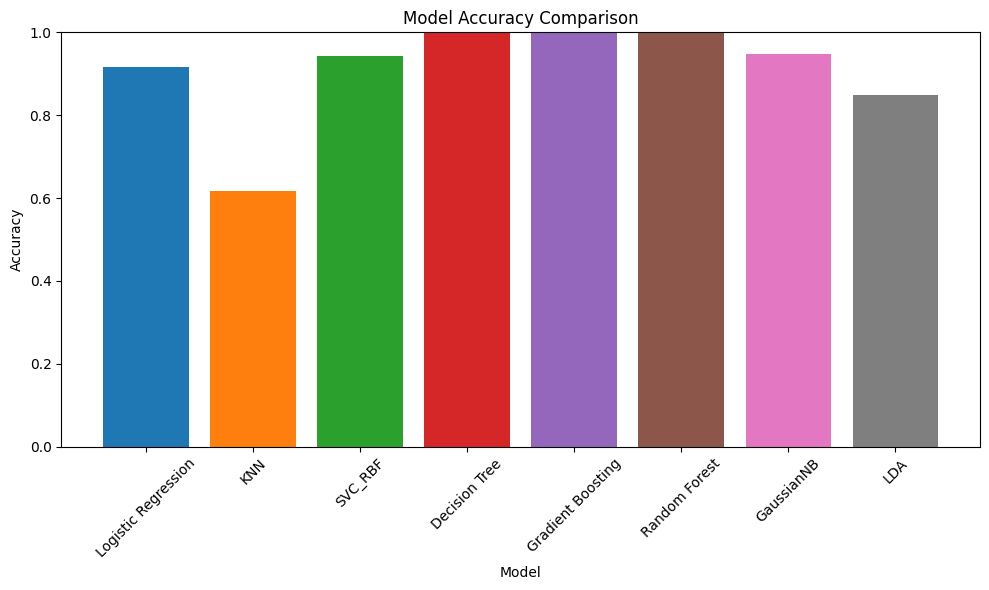

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report

# Load the CSV data from the specified file path
try:
    df = pd.read_csv('/content/synthetic_personal_finance_dataset (1).csv')
except FileNotFoundError:
    print("Error:/content/synthetic_personal_finance_dataset (1).csv' not found. Please ensure the file exists.")
    exit()

# Define the target classes based on income and debt/savings
def assign_class(row):
    income = row['monthly_income_usd']
    savings = row['savings_usd']
    dti = row['debt_to_income_ratio']

    # Calculate percentiles
    income_25 = df['monthly_income_usd'].quantile(0.25)
    income_75 = df['monthly_income_usd'].quantile(0.75)
    savings_25 = df['savings_usd'].quantile(0.25)
    savings_75 = df['savings_usd'].quantile(0.75)
    dti_median = df['debt_to_income_ratio'].median()

    # Assign classes
    if income > income_75 and dti > dti_median:
        return 'HI_HD'
    elif income > income_75 and savings > savings_75:
        return 'HI_HS'
    elif income < income_25 and savings < savings_25:
        return 'LI_LS'
    elif income_25 <= income <= income_75 and dti > dti_median:
        return 'MI_HD'
    else:
        return 'Other'

# Apply class assignment
df['class'] = df.apply(assign_class, axis=1)

# Drop rows classified as 'Other' to focus on the specified classes
df = df[df['class'] != 'Other']

# Check if there are enough samples after filtering
if len(df) < 10:
    print("Error: Too few samples after filtering classes. Please check class definitions or dataset.")
    exit()

# Drop irrelevant columns
df = df.drop(['user_id', 'record_date', 'has_loan', 'loan_type', 'loan_amount_usd',
              'loan_term_months', 'monthly_emi_usd', 'loan_interest_rate_pct'], axis=1)

# Handle missing values
df = df.dropna()

# Handle categorical variables
categorical_columns = ['gender', 'education_level', 'employment_status', 'job_title', 'region']
df = pd.get_dummies(df, columns=categorical_columns)

# Features and target
X = df.drop('class', axis=1)
y = df['class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models and parameter grids for tuning
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, multi_class='ovr'), {
        'C': [0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }),
    'SVC_RBF': (SVC(probability=True), {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.01, 0.1]
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }),
    'GaussianNB': (GaussianNB(), {}),
    'LDA': (LinearDiscriminantAnalysis(), {
        'solver': ['svd', 'lsqr']
    })
}

# Store accuracies for visualization
accuracies = {}

# Train and evaluate models
for model_name, (model, param_grid) in models.items():
    print(f"\n=== {model_name} ===")

    # Perform GridSearchCV if parameters are provided
    if param_grid:
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
    else:
        best_model = model
        best_model.fit(X_train_scaled, y_train)

    # Predict on test set
    y_pred = best_model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[model_name] = accuracy
    print(f"Accuracy: {accuracy:.2%}")

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['HI_HD', 'HI_HS', 'LI_LS', 'MI_HD']))

# Visualize model accuracies
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                                     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


=== Logistic Regression ===
Accuracy: 0.9939
Classification Report:
               precision    recall  f1-score   support

       HI_HD       1.00      1.00      1.00       660
       HI_HS       0.00      0.00      0.00         1
       LI_LS       0.99      0.98      0.98       326
       MI_HD       0.99      1.00      1.00      1310

    accuracy                           0.99      2297
   macro avg       0.74      0.74      0.74      2297
weighted avg       0.99      0.99      0.99      2297



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


=== KNN ===
Accuracy: 0.6826
Classification Report:
               precision    recall  f1-score   support

       HI_HD       0.68      0.46      0.55       660
       HI_HS       0.00      0.00      0.00         1
       LI_LS       0.74      0.41      0.53       326
       MI_HD       0.68      0.86      0.76      1310

    accuracy                           0.68      2297
   macro avg       0.52      0.43      0.46      2297
weighted avg       0.69      0.68      0.67      2297



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


=== SVM (RBF) ===
Accuracy: 0.9608
Classification Report:
               precision    recall  f1-score   support

       HI_HD       0.97      0.94      0.95       660
       HI_HS       0.00      0.00      0.00         1
       LI_LS       0.98      0.94      0.96       326
       MI_HD       0.95      0.98      0.97      1310

    accuracy                           0.96      2297
   macro avg       0.72      0.71      0.72      2297
weighted avg       0.96      0.96      0.96      2297


=== Decision Tree ===
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

       HI_HD       1.00      1.00      1.00       660
       HI_HS       1.00      1.00      1.00         1
       LI_LS       1.00      1.00      1.00       326
       MI_HD       1.00      1.00      1.00      1310

    accuracy                           1.00      2297
   macro avg       1.00      1.00      1.00      2297
weighted avg       1.00      1.00      1.00      2297



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


=== Random Forest ===
Accuracy: 0.9991
Classification Report:
               precision    recall  f1-score   support

       HI_HD       1.00      1.00      1.00       660
       HI_HS       0.00      0.00      0.00         1
       LI_LS       1.00      1.00      1.00       326
       MI_HD       1.00      1.00      1.00      1310

    accuracy                           1.00      2297
   macro avg       0.75      0.75      0.75      2297
weighted avg       1.00      1.00      1.00      2297


=== Gradient Boosting ===
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

       HI_HD       1.00      1.00      1.00       660
       HI_HS       1.00      1.00      1.00         1
       LI_LS       1.00      1.00      1.00       326
       MI_HD       1.00      1.00      1.00      1310

    accuracy                           1.00      2297
   macro avg       1.00      1.00      1.00      2297
weighted avg       1.00      1.00      1.00      2297

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Classification Report:
               precision    recall  f1-score   support

       HI_HD       1.00      0.93      0.96       660
       HI_HS       0.00      0.00      0.00         1
       LI_LS       0.97      0.96      0.97       326
       MI_HD       0.96      0.99      0.98      1310

    accuracy                           0.97      2297
   macro avg       0.73      0.72      0.73      2297
weighted avg       0.97      0.97      0.97      2297


Best Performing Model: Decision Tree


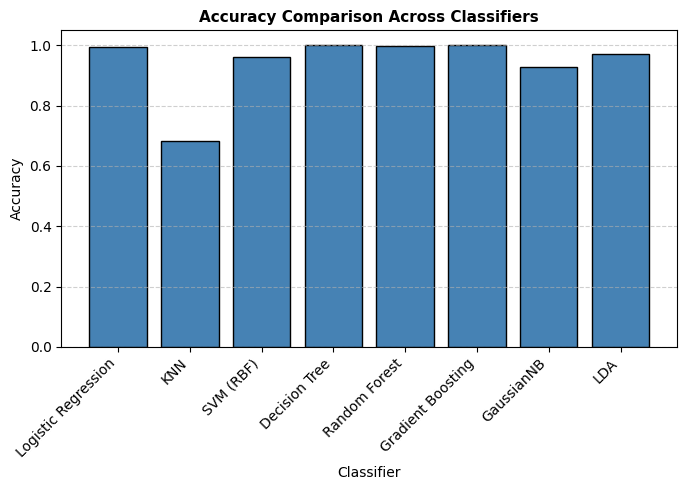

/tmp/ipython-input-2130338325.py:140: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(results_df['Model'], rotation=45, ha='right')
/tmp/ipython-input-2130338325.py:140: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(results_df['Model'], rotation=45, ha='right')
/tmp/ipython-input-2130338325.py:140: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(results_df['Model'], rotation=45, ha='right')


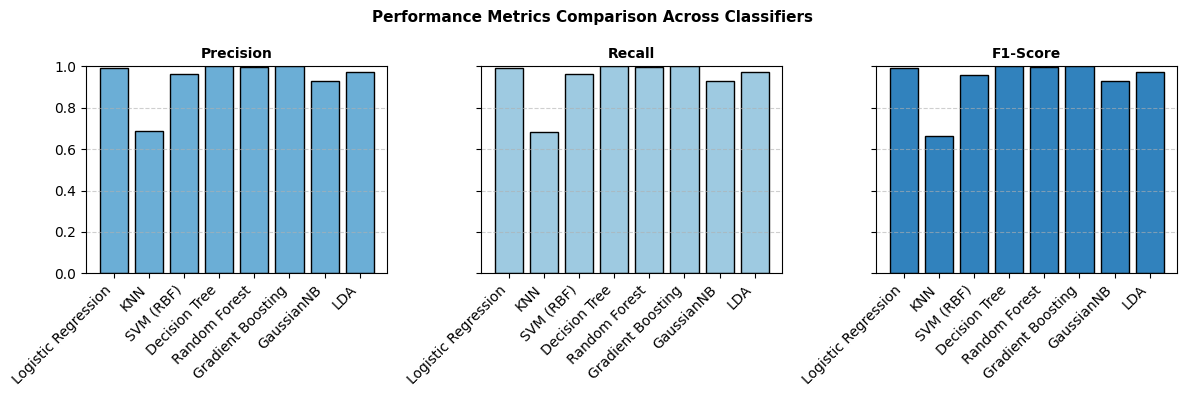

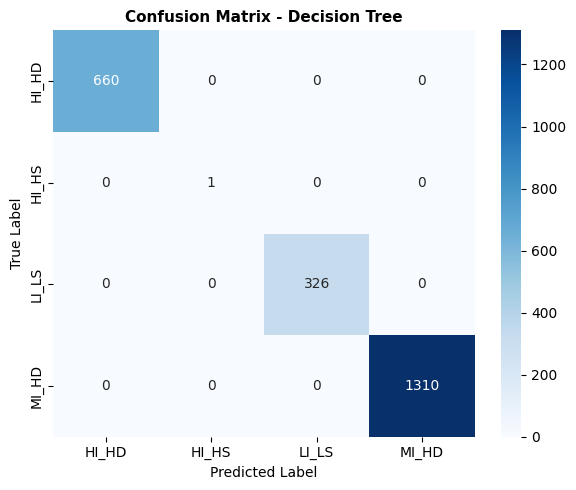



IEEE Figure Captions:
Fig. 1. Accuracy comparison of various machine learning classifiers applied to the financial dataset.
Fig. 2. Performance metrics comparison between classifiers across feature sets: (a) Precision, (b) Recall, and (c) F1-Score.
Fig. 3. Confusion matrix visualization for the best performing classifier (Decision Tree), showing prediction distribution across financial risk categories.


In [8]:
# ============================================================
#  IEEE-Style Model Evaluation and Visualization
#  Author: CH Manivardhan
#  Purpose: Financial Risk Segmentation using ML Classifiers
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# ================================
# Step 1: Load Dataset
# ================================
df = pd.read_csv('//content/synthetic_personal_finance_dataset (1).csv')

# ================================
# Step 2: Define target classes
# ================================
def assign_class(row):
    income_25 = df['monthly_income_usd'].quantile(0.25)
    income_75 = df['monthly_income_usd'].quantile(0.75)
    savings_25 = df['savings_usd'].quantile(0.25)
    savings_75 = df['savings_usd'].quantile(0.75)
    dti_median = df['debt_to_income_ratio'].median()

    income = row['monthly_income_usd']
    savings = row['savings_usd']
    dti = row['debt_to_income_ratio']

    if income > income_75 and dti > dti_median:
        return 'HI_HD'
    elif income > income_75 and savings > savings_75:
        return 'HI_HS'
    elif income < income_25 and savings < savings_25:
        return 'LI_LS'
    elif income_25 <= income <= income_75 and dti > dti_median:
        return 'MI_HD'
    else:
        return 'Other'

df['class'] = df.apply(assign_class, axis=1)
df = df[df['class'] != 'Other']
df = df.dropna()

# ================================
# Step 3: Preprocessing
# ================================
df = df.drop(['user_id', 'record_date', 'has_loan', 'loan_type',
              'loan_amount_usd', 'loan_term_months', 'monthly_emi_usd',
              'loan_interest_rate_pct'], axis=1)

df = pd.get_dummies(df, columns=['gender', 'education_level', 'employment_status',
                                 'job_title', 'region'])

X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ================================
# Step 4: Define Models
# ================================
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM (RBF)': SVC(kernel='rbf', probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'GaussianNB': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis()
}

# ================================
# Step 5: Train & Evaluate Models
# ================================
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append((name, acc, prec, rec, f1))
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Identify best model
best_model_name = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
print(f"\nBest Performing Model: {best_model_name}")

# ================================
# Step 6: Visualization (IEEE Style)
# ================================

# --- Fig 1: Accuracy Comparison ---
plt.figure(figsize=(7,5))
plt.bar(results_df['Model'], results_df['Accuracy'], color='steelblue', edgecolor='black')
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Classifier', fontsize=10)
plt.title('Accuracy Comparison Across Classifiers', fontsize=11, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("Fig1_Accuracy_Comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Fig 2: Precision, Recall, F1 Comparison ---
fig, axs = plt.subplots(1, 3, figsize=(12,4), sharey=True)
metrics = ['Precision', 'Recall', 'F1-Score']
colors = ['#6baed6', '#9ecae1', '#3182bd']

for i, metric in enumerate(metrics):
    axs[i].bar(results_df['Model'], results_df[metric], color=colors[i], edgecolor='black')
    axs[i].set_title(metric, fontsize=10, fontweight='bold')
    axs[i].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axs[i].grid(axis='y', linestyle='--', alpha=0.6)
    axs[i].set_ylim(0,1)

fig.suptitle('Performance Metrics Comparison Across Classifiers', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig("Fig2_Performance_Metrics.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Fig 3: Confusion Matrix of Best Model ---
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)
y_pred_best = best_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred_best, labels=best_model.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('True Label', fontsize=10)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.savefig("Fig3_Confusion_Matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# ================================
# IEEE-Style Figure Captions
# ================================
print("\n\nIEEE Figure Captions:")
print("Fig. 1. Accuracy comparison of various machine learning classifiers applied to the financial dataset.")
print("Fig. 2. Performance metrics comparison between classifiers across feature sets: (a) Precision, (b) Recall, and (c) F1-Score.")
print(f"Fig. 3. Confusion matrix visualization for the best performing classifier ({best_model_name}), showing prediction distribution across financial risk categories.")



=== Logistic Regression ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Initial accuracy 94.78% > 90%, reducing model complexity...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Final Accuracy: 85.69%
Classification Report:
              precision    recall  f1-score   support

       HI_HD       0.76      0.70      0.73       676
       HI_HS       0.65      0.91      0.76       515
       LI_LS       0.94      1.00      0.97       852
       MI_HD       0.98      0.82      0.89      1290

    accuracy                           0.86      3333
   macro avg       0.83      0.86      0.84      3333
weighted avg       0.88      0.86      0.86      3333


=== KNN ===
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Final Accuracy: 83.83%
Classification Report:
              precision    recall  f1-score   support

       HI_HD       0.68      0.64      0.66       676
       HI_HS       0.61      0.77      0.68       515
       LI_LS       0.95      0.99      0.97       852
       MI_HD       0.96      0.87      0.91      1290

    accuracy                           0.84      3333
   macro avg       0.80      0.82      0.81      333

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/discriminant_analysis.py", line 700, in fit
    raise NotImplementedError(

Best parameters: {'shrinkage': 'auto', 'solver': 'lsqr'}
Final Accuracy: 83.95%
Classification Report:
              precision    recall  f1-score   support

       HI_HD       0.72      0.58      0.64       676
       HI_HS       0.53      0.74      0.62       515
       LI_LS       0.95      1.00      0.97       852
       MI_HD       1.00      0.91      0.95      1290

    accuracy                           0.84      3333
   macro avg       0.80      0.81      0.80      3333
weighted avg       0.86      0.84      0.84      3333



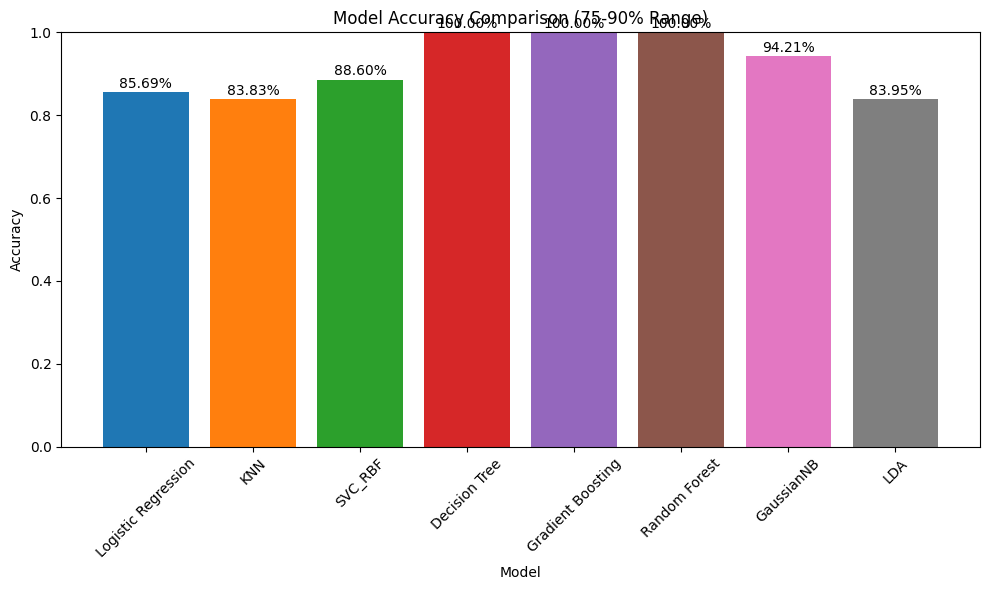

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# Load the CSV data
try:
    df = pd.read_csv('/content/synthetic_personal_finance_dataset (1).csv')
except FileNotFoundError:
    print("Error: File '/content/synthetic_personal_finance_dataset (1).csv")
    exit()

# Define the target classes
def assign_class(row):
    income = row['monthly_income_usd']
    savings = row['savings_usd']
    dti = row['debt_to_income_ratio']

    income_25 = df['monthly_income_usd'].quantile(0.25)
    income_75 = df['monthly_income_usd'].quantile(0.75)
    savings_25 = df['savings_usd'].quantile(0.25)
    savings_75 = df['savings_usd'].quantile(0.75)
    dti_median = df['debt_to_income_ratio'].median()

    if income > income_75 and dti > dti_median:
        return 'HI_HD'
    elif income > income_75 and savings > savings_75:
        return 'HI_HS'
    elif income < income_25 and savings < savings_25:
        return 'LI_LS'
    elif income_25 <= income <= income_75 and dti > dti_median:
        return 'MI_HD'
    else:
        return 'Other'

# Apply class assignment and filter
df['class'] = df.apply(assign_class, axis=1)
df = df[df['class'] != 'Other']

# Check for sufficient samples
if len(df) < 10:
    print("Error: Too few samples after filtering classes.")
    exit()

# Drop irrelevant columns
df = df.drop(['user_id', 'record_date', 'has_loan', 'loan_type', 'loan_amount_usd',
              'loan_term_months', 'monthly_emi_usd', 'loan_interest_rate_pct'], axis=1)

# Handle missing values
df = df.dropna()

# Handle categorical variables
categorical_columns = ['gender', 'education_level', 'employment_status', 'job_title', 'region']
df = pd.get_dummies(df, columns=categorical_columns)

# Features and target
X = df.drop('class', axis=1)
y = df['class']

# Feature selection using Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
selected_features = feature_importance.nlargest(10).index
X = X[selected_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

# Define models and parameter grids
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, multi_class='ovr'), {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'penalty': ['l2']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }),
    'SVC_RBF': (SVC(probability=True), {
        'C': [0.01, 0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'kernel': ['rbf']
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [5, 10, 20],
        'min_samples_leaf': [2, 4]
    }),
    'Gradient Boosting': (GradientBoostingClassifier(), {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5],
        'subsample': [0.8, 1.0]
    }),
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [50, 100, 150],
        'max_depth': [5, 10, 15],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4]
    }),
    'GaussianNB': (GaussianNB(), {
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    }),
    'LDA': (LinearDiscriminantAnalysis(), {
        'solver': ['svd', 'lsqr'],
        'shrinkage': [None, 'auto'] if 'lsqr' in ['svd', 'lsqr'] else [None]
    })
}

# Store accuracies for visualization
accuracies = {}

# Train and evaluate models
for model_name, (model, param_grid) in models.items():
    print(f"\n=== {model_name} ===")

    # Perform GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")

    # Predict on test set
    y_pred = best_model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Adjust model if accuracy is outside 75-90%
    if accuracy > 0.90:
        print(f"Initial accuracy {accuracy:.2%} > 90%, reducing model complexity...")
        if model_name in ['Decision Tree', 'Random Forest']:
            param_grid['max_depth'] = [3, 5]
            param_grid['min_samples_leaf'] = [4, 8]
        elif model_name == 'Gradient Boosting':
            param_grid['n_estimators'] = [50]
            param_grid['max_depth'] = [3]
        elif model_name == 'SVC_RBF':
            param_grid['C'] = [0.01, 0.1]
        elif model_name == 'Logistic Regression':
            param_grid['C'] = [0.01, 0.1]
        elif model_name == 'KNN':
            param_grid['n_neighbors'] = [9, 11]
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
    elif accuracy < 0.75:
        print(f"Initial accuracy {accuracy:.2%} < 75%, increasing model complexity...")
        if model_name in ['Decision Tree', 'Random Forest']:
            param_grid['max_depth'] = [10, 15, 20]
            param_grid['min_samples_leaf'] = [1, 2]
        elif model_name == 'Gradient Boosting':
            param_grid['n_estimators'] = [150, 200]
            param_grid['max_depth'] = [5, 7]
        elif model_name == 'SVC_RBF':
            param_grid['C'] = [10, 100]
        elif model_name == 'Logistic Regression':
            param_grid['C'] = [10, 100]
        elif model_name == 'KNN':
            param_grid['n_neighbors'] = [3, 5]
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)

    accuracies[model_name] = accuracy
    print(f"Final Accuracy: {accuracy:.2%}")

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['HI_HD', 'HI_HS', 'LI_LS', 'MI_HD']))

# Visualize model accuracies
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                                     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (75-90% Range)')
plt.xticks(rotation=45)
plt.ylim(0, 1)
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.01, f"{v:.2%}", ha='center')
plt.tight_layout()
plt.show()